# Deep cortical machine learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.7601054974132366 -2.5583515237895775
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [17]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [18]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * targetQs[1:])
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                     labels=reward*tf.ones_like(Qs_logits)))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
                                                                     labels=tf.reshape(tf.nn.sigmoid(targetQs[1:]),
                                                                                       shape=[-1, 1])))
    d_loss = d_lossR + d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [19]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [20]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [21]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [22]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [23]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [24]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [ ]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
d_lossR_list, d_lossQ_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            #break
            print('Won!')
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints4/model.ckpt')

Episode:0 meanR:78.0000 gloss:0.0057 dloss:1.3892 dlossR:0.6960 dlossQ:0.6932
Episode:1 meanR:56.5000 gloss:-0.0013 dloss:1.3854 dlossR:0.6922 dlossQ:0.6932
Episode:2 meanR:44.6667 gloss:-0.0171 dloss:1.3748 dlossR:0.6817 dlossQ:0.6931
Episode:3 meanR:35.5000 gloss:-0.0537 dloss:1.3490 dlossR:0.6566 dlossQ:0.6923
Episode:4 meanR:30.8000 gloss:-0.0828 dloss:1.3306 dlossR:0.6392 dlossQ:0.6913
Episode:5 meanR:28.1667 gloss:-0.0926 dloss:1.3239 dlossR:0.6330 dlossQ:0.6909
Episode:6 meanR:27.5714 gloss:-0.0953 dloss:1.3237 dlossR:0.6329 dlossQ:0.6908
Episode:7 meanR:30.1250 gloss:-0.1244 dloss:1.3134 dlossR:0.6243 dlossQ:0.6891
Episode:8 meanR:32.3333 gloss:-0.1193 dloss:1.3167 dlossR:0.6272 dlossQ:0.6894
Episode:9 meanR:35.7000 gloss:-0.1922 dloss:1.2842 dlossR:0.6011 dlossQ:0.6831
Episode:10 meanR:36.1818 gloss:-0.0995 dloss:1.3251 dlossR:0.6345 dlossQ:0.6906
Episode:11 meanR:36.4167 gloss:-0.1061 dloss:1.3202 dlossR:0.6302 dlossQ:0.6900
Episode:12 meanR:35.0000 gloss:-0.1009 dloss:1.3159

Episode:103 meanR:48.2200 gloss:-1.5477 dloss:0.6943 dlossR:0.3693 dlossQ:0.3250
Episode:104 meanR:50.2800 gloss:-1.4790 dloss:1.3847 dlossR:1.0487 dlossQ:0.3360
Episode:105 meanR:52.2300 gloss:-1.4370 dloss:1.3450 dlossR:0.9955 dlossQ:0.3494
Episode:106 meanR:53.3700 gloss:-1.4224 dloss:1.0470 dlossR:0.6929 dlossQ:0.3541
Episode:107 meanR:54.0900 gloss:-1.4057 dloss:0.9769 dlossR:0.6167 dlossQ:0.3602
Episode:108 meanR:54.5400 gloss:-1.4596 dloss:0.8741 dlossR:0.5256 dlossQ:0.3485
Episode:109 meanR:54.8200 gloss:-1.4102 dloss:0.8791 dlossR:0.5160 dlossQ:0.3632
Episode:110 meanR:55.1900 gloss:-1.4200 dloss:0.8293 dlossR:0.4599 dlossQ:0.3694
Episode:111 meanR:55.1900 gloss:-1.3987 dloss:0.6561 dlossR:0.2900 dlossQ:0.3661
Episode:112 meanR:55.4200 gloss:-1.4022 dloss:0.6644 dlossR:0.2989 dlossQ:0.3655
Episode:113 meanR:55.7000 gloss:-1.4054 dloss:0.6677 dlossR:0.3014 dlossQ:0.3663
Episode:114 meanR:56.1500 gloss:-1.3902 dloss:0.7150 dlossR:0.3476 dlossQ:0.3674
Episode:115 meanR:56.2300 gl

Episode:210 meanR:39.1000 gloss:-1.8394 dloss:1.1385 dlossR:0.8829 dlossQ:0.2556
Episode:211 meanR:39.6000 gloss:-1.5664 dloss:0.8230 dlossR:0.5068 dlossQ:0.3163
Episode:212 meanR:40.1100 gloss:-1.7050 dloss:0.8341 dlossR:0.5470 dlossQ:0.2871
Episode:213 meanR:40.6400 gloss:-1.8697 dloss:0.8561 dlossR:0.5950 dlossQ:0.2611
Episode:214 meanR:40.6200 gloss:-1.3090 dloss:0.7271 dlossR:0.3370 dlossQ:0.3901
Episode:215 meanR:40.7000 gloss:-1.2157 dloss:0.6800 dlossR:0.2638 dlossQ:0.4162
Episode:216 meanR:40.6800 gloss:-1.2361 dloss:0.6412 dlossR:0.2321 dlossQ:0.4091
Episode:217 meanR:40.6300 gloss:-1.4823 dloss:0.5049 dlossR:0.1664 dlossQ:0.3385
Episode:218 meanR:40.5400 gloss:-1.8020 dloss:0.4041 dlossR:0.1426 dlossQ:0.2615
Episode:219 meanR:40.5500 gloss:-1.3046 dloss:0.5839 dlossR:0.1941 dlossQ:0.3898
Episode:220 meanR:40.5700 gloss:-1.3270 dloss:0.6094 dlossR:0.2258 dlossQ:0.3836
Episode:221 meanR:40.6300 gloss:-1.3017 dloss:0.6136 dlossR:0.2240 dlossQ:0.3896
Episode:222 meanR:40.7400 gl

Episode:313 meanR:40.2100 gloss:-1.6666 dloss:0.7939 dlossR:0.5040 dlossQ:0.2899
Episode:314 meanR:40.3800 gloss:-1.6511 dloss:0.7066 dlossR:0.4148 dlossQ:0.2919
Episode:315 meanR:40.3300 gloss:-1.6995 dloss:0.4967 dlossR:0.2114 dlossQ:0.2854
Episode:316 meanR:40.6400 gloss:-1.6359 dloss:0.6426 dlossR:0.3443 dlossQ:0.2984
Episode:317 meanR:41.0400 gloss:-1.5948 dloss:0.6427 dlossR:0.3363 dlossQ:0.3064
Episode:318 meanR:41.3700 gloss:-1.6338 dloss:0.5962 dlossR:0.3001 dlossQ:0.2961
Episode:319 meanR:41.7000 gloss:-1.6157 dloss:0.6167 dlossR:0.3147 dlossQ:0.3021
Episode:320 meanR:41.9000 gloss:-1.5444 dloss:0.6158 dlossR:0.2954 dlossQ:0.3204
Episode:321 meanR:42.2600 gloss:-1.5701 dloss:0.6769 dlossR:0.3636 dlossQ:0.3133
Episode:322 meanR:42.6000 gloss:-1.5754 dloss:0.6678 dlossR:0.3551 dlossQ:0.3127
Episode:323 meanR:42.8500 gloss:-1.5309 dloss:0.6113 dlossR:0.2869 dlossQ:0.3244
Episode:324 meanR:43.0600 gloss:-1.5664 dloss:0.5974 dlossR:0.2822 dlossQ:0.3152
Episode:325 meanR:43.4500 gl

Episode:418 meanR:67.4700 gloss:-1.3882 dloss:0.6832 dlossR:0.3159 dlossQ:0.3673
Episode:419 meanR:67.3100 gloss:-1.4028 dloss:0.6161 dlossR:0.2513 dlossQ:0.3648
Episode:420 meanR:67.3700 gloss:-1.4390 dloss:0.6773 dlossR:0.3237 dlossQ:0.3536
Episode:421 meanR:67.1600 gloss:-1.4240 dloss:0.6331 dlossR:0.2746 dlossQ:0.3585
Episode:422 meanR:66.7700 gloss:-1.5536 dloss:0.5038 dlossR:0.1808 dlossQ:0.3230
Episode:423 meanR:66.5600 gloss:-1.5925 dloss:0.5055 dlossR:0.1923 dlossQ:0.3132
Episode:424 meanR:66.4000 gloss:-1.5138 dloss:0.5496 dlossR:0.2155 dlossQ:0.3341
Episode:425 meanR:66.1700 gloss:-1.5576 dloss:0.5640 dlossR:0.2409 dlossQ:0.3231
Episode:426 meanR:65.7200 gloss:-1.7584 dloss:0.4313 dlossR:0.1594 dlossQ:0.2719
Episode:427 meanR:64.6000 gloss:-2.7711 dloss:0.2490 dlossR:0.1187 dlossQ:0.1303
Episode:428 meanR:63.8700 gloss:-1.5290 dloss:0.5634 dlossR:0.2349 dlossQ:0.3285
Episode:429 meanR:64.2500 gloss:-1.4894 dloss:0.6691 dlossR:0.3309 dlossQ:0.3382
Episode:430 meanR:65.4200 gl

Episode:523 meanR:47.4600 gloss:-1.2531 dloss:0.7854 dlossR:0.3780 dlossQ:0.4074
Episode:524 meanR:47.7100 gloss:-1.2800 dloss:0.7287 dlossR:0.3296 dlossQ:0.3991
Episode:525 meanR:47.8800 gloss:-1.2839 dloss:0.7195 dlossR:0.3218 dlossQ:0.3977
Episode:526 meanR:48.5500 gloss:-1.2537 dloss:0.8576 dlossR:0.4505 dlossQ:0.4070
Episode:527 meanR:49.0100 gloss:-1.2944 dloss:0.7495 dlossR:0.3550 dlossQ:0.3945
Episode:528 meanR:49.4100 gloss:-1.2801 dloss:0.8025 dlossR:0.4036 dlossQ:0.3989
Episode:529 meanR:49.3200 gloss:-1.3304 dloss:0.6840 dlossR:0.3002 dlossQ:0.3838
Episode:530 meanR:48.8500 gloss:-1.2559 dloss:0.8490 dlossR:0.4429 dlossQ:0.4061
Episode:531 meanR:49.1300 gloss:-1.3179 dloss:0.7835 dlossR:0.3960 dlossQ:0.3874
Episode:532 meanR:49.7300 gloss:-1.2862 dloss:0.8819 dlossR:0.4848 dlossQ:0.3971
Episode:533 meanR:50.7900 gloss:-1.2530 dloss:1.0280 dlossR:0.6204 dlossQ:0.4076
Episode:534 meanR:55.0300 gloss:-1.0722 dloss:2.0732 dlossR:1.6091 dlossQ:0.4641
Episode:535 meanR:58.9100 gl

Episode:628 meanR:73.0700 gloss:-1.3521 dloss:0.6193 dlossR:0.2369 dlossQ:0.3823
Episode:629 meanR:72.8500 gloss:-1.4733 dloss:0.5510 dlossR:0.2043 dlossQ:0.3467
Episode:630 meanR:72.1800 gloss:-1.6261 dloss:0.4673 dlossR:0.1628 dlossQ:0.3045
Episode:631 meanR:71.6300 gloss:-1.7602 dloss:0.4225 dlossR:0.1509 dlossQ:0.2716
Episode:632 meanR:70.8600 gloss:-1.8024 dloss:0.4171 dlossR:0.1563 dlossQ:0.2609
Episode:633 meanR:69.6700 gloss:-1.8026 dloss:0.4018 dlossR:0.1397 dlossQ:0.2621
Episode:634 meanR:65.2300 gloss:-2.0289 dloss:0.3541 dlossR:0.1389 dlossQ:0.2153
Episode:635 meanR:61.2500 gloss:-1.8438 dloss:0.3960 dlossR:0.1420 dlossQ:0.2540
Episode:636 meanR:59.8000 gloss:-1.8699 dloss:0.3913 dlossR:0.1441 dlossQ:0.2472
Episode:637 meanR:56.8700 gloss:-1.6937 dloss:0.4467 dlossR:0.1573 dlossQ:0.2893
Episode:638 meanR:55.2200 gloss:-1.3738 dloss:0.6337 dlossR:0.2575 dlossQ:0.3761
Episode:639 meanR:50.6000 gloss:-1.3317 dloss:0.6760 dlossR:0.2880 dlossQ:0.3880
Episode:640 meanR:48.9700 gl

Episode:730 meanR:65.4000 gloss:-1.3284 dloss:0.7804 dlossR:0.3898 dlossQ:0.3906
Episode:731 meanR:70.2800 gloss:-1.1822 dloss:2.3108 dlossR:1.8755 dlossQ:0.4353
Episode:732 meanR:70.8400 gloss:-1.1416 dloss:0.8565 dlossR:0.4102 dlossQ:0.4463
Episode:733 meanR:71.1900 gloss:-1.1597 dloss:0.7671 dlossR:0.3263 dlossQ:0.4407
Episode:734 meanR:71.4100 gloss:-1.2027 dloss:0.7116 dlossR:0.2842 dlossQ:0.4274
Episode:735 meanR:71.5000 gloss:-1.2398 dloss:0.6464 dlossR:0.2301 dlossQ:0.4163
Episode:736 meanR:71.4600 gloss:-1.7505 dloss:0.4253 dlossR:0.1444 dlossQ:0.2809
Episode:737 meanR:71.7300 gloss:-1.1589 dloss:0.7500 dlossR:0.3092 dlossQ:0.4407
Episode:738 meanR:72.1000 gloss:-1.1127 dloss:0.8596 dlossR:0.4045 dlossQ:0.4550
Episode:739 meanR:74.2900 gloss:-1.1277 dloss:1.4716 dlossR:1.0197 dlossQ:0.4518
Episode:740 meanR:74.6500 gloss:-1.1185 dloss:0.8783 dlossR:0.4262 dlossQ:0.4521
Episode:741 meanR:74.7300 gloss:-1.1935 dloss:0.7578 dlossR:0.3283 dlossQ:0.4295
Episode:742 meanR:74.5400 gl

Episode:833 meanR:78.0100 gloss:-1.2801 dloss:1.0912 dlossR:0.6887 dlossQ:0.4025
Episode:834 meanR:82.6700 gloss:-1.3236 dloss:2.4398 dlossR:2.0506 dlossQ:0.3891
Episode:835 meanR:83.4400 gloss:-1.3287 dloss:0.9011 dlossR:0.5125 dlossQ:0.3886
Episode:836 meanR:84.3100 gloss:-1.3241 dloss:0.8963 dlossR:0.5053 dlossQ:0.3909
Episode:837 meanR:84.6000 gloss:-1.3885 dloss:0.7872 dlossR:0.4110 dlossQ:0.3762
Episode:838 meanR:84.5200 gloss:-1.3971 dloss:0.7448 dlossR:0.3726 dlossQ:0.3722
Episode:839 meanR:82.1100 gloss:-1.6166 dloss:0.4975 dlossR:0.1811 dlossQ:0.3163
Episode:840 meanR:82.2000 gloss:-1.3460 dloss:0.8519 dlossR:0.4658 dlossQ:0.3861
Episode:841 meanR:83.0600 gloss:-1.2997 dloss:1.0434 dlossR:0.6424 dlossQ:0.4010
Episode:842 meanR:84.3800 gloss:-1.2584 dloss:1.2033 dlossR:0.7902 dlossQ:0.4131
Episode:843 meanR:85.8300 gloss:-1.2727 dloss:1.2229 dlossR:0.8132 dlossQ:0.4097
Episode:844 meanR:86.2300 gloss:-1.3986 dloss:0.7653 dlossR:0.3850 dlossQ:0.3802
Episode:845 meanR:86.5500 gl

Episode:934 meanR:108.2800 gloss:-0.7971 dloss:1.4476 dlossR:0.8893 dlossQ:0.5583
Episode:935 meanR:110.2400 gloss:-0.7750 dloss:1.5121 dlossR:0.9482 dlossQ:0.5639
Episode:936 meanR:110.5000 gloss:-0.7348 dloss:1.1348 dlossR:0.5606 dlossQ:0.5742
Episode:937 meanR:111.0500 gloss:-0.8902 dloss:1.1106 dlossR:0.5811 dlossQ:0.5295
Episode:938 meanR:111.3400 gloss:-0.7632 dloss:1.0533 dlossR:0.4878 dlossQ:0.5654
Episode:939 meanR:111.7500 gloss:-0.7555 dloss:0.9877 dlossR:0.4187 dlossQ:0.5690
Episode:940 meanR:111.1000 gloss:-1.0149 dloss:0.7596 dlossR:0.2709 dlossQ:0.4887
Episode:941 meanR:110.0000 gloss:-0.9107 dloss:0.8237 dlossR:0.3039 dlossQ:0.5198
Episode:942 meanR:108.4000 gloss:-1.0948 dloss:0.7081 dlossR:0.2452 dlossQ:0.4629
Episode:943 meanR:106.7800 gloss:-1.0484 dloss:0.7402 dlossR:0.2620 dlossQ:0.4782
Episode:944 meanR:106.3700 gloss:-1.1835 dloss:0.6769 dlossR:0.2418 dlossQ:0.4351
Episode:945 meanR:105.9000 gloss:-1.4538 dloss:0.5583 dlossR:0.1969 dlossQ:0.3614
Episode:946 mean

Episode:1040 meanR:65.3000 gloss:-1.7133 dloss:0.4332 dlossR:0.1515 dlossQ:0.2817
Episode:1041 meanR:65.2500 gloss:-1.7139 dloss:0.4570 dlossR:0.1745 dlossQ:0.2824
Episode:1042 meanR:65.2400 gloss:-1.8209 dloss:0.4140 dlossR:0.1561 dlossQ:0.2579
Episode:1043 meanR:65.2000 gloss:-1.8556 dloss:0.4045 dlossR:0.1546 dlossQ:0.2500
Episode:1044 meanR:65.1200 gloss:-1.8526 dloss:0.3894 dlossR:0.1392 dlossQ:0.2502
Episode:1045 meanR:65.1100 gloss:-1.8556 dloss:0.3888 dlossR:0.1390 dlossQ:0.2498
Episode:1046 meanR:64.5300 gloss:-1.8918 dloss:0.3951 dlossR:0.1524 dlossQ:0.2426
Episode:1047 meanR:61.3700 gloss:-1.7525 dloss:0.4349 dlossR:0.1618 dlossQ:0.2731
Episode:1048 meanR:61.3200 gloss:-1.6366 dloss:0.5091 dlossR:0.2055 dlossQ:0.3036
Episode:1049 meanR:61.6200 gloss:-1.7141 dloss:0.5896 dlossR:0.2942 dlossQ:0.2954
Episode:1050 meanR:61.9800 gloss:-1.7432 dloss:0.6141 dlossR:0.3280 dlossQ:0.2861
Episode:1051 meanR:62.1300 gloss:-1.6403 dloss:0.5245 dlossR:0.2201 dlossQ:0.3044
Episode:1052 mea

Episode:1141 meanR:40.5800 gloss:-1.7101 dloss:0.6479 dlossR:0.3550 dlossQ:0.2929
Episode:1142 meanR:41.1500 gloss:-1.6700 dloss:0.7378 dlossR:0.4381 dlossQ:0.2997
Episode:1143 meanR:42.7700 gloss:-1.4859 dloss:1.2193 dlossR:0.8732 dlossQ:0.3461
Episode:1144 meanR:44.7300 gloss:-1.5821 dloss:1.3685 dlossR:1.0494 dlossQ:0.3191
Episode:1145 meanR:45.6200 gloss:-1.5411 dloss:0.8935 dlossR:0.5590 dlossQ:0.3345
Episode:1146 meanR:46.4300 gloss:-1.5905 dloss:0.8548 dlossR:0.5387 dlossQ:0.3161
Episode:1147 meanR:46.7200 gloss:-1.6738 dloss:0.5959 dlossR:0.3037 dlossQ:0.2922
Episode:1148 meanR:46.6200 gloss:-1.8323 dloss:0.3949 dlossR:0.1442 dlossQ:0.2507
Episode:1149 meanR:46.3600 gloss:-1.9688 dloss:0.3635 dlossR:0.1436 dlossQ:0.2198
Episode:1150 meanR:46.0000 gloss:-1.9717 dloss:0.3485 dlossR:0.1288 dlossQ:0.2198
Episode:1151 meanR:45.9100 gloss:-1.9049 dloss:0.3935 dlossR:0.1606 dlossQ:0.2329
Episode:1152 meanR:45.8800 gloss:-1.9967 dloss:0.3437 dlossR:0.1284 dlossQ:0.2153
Episode:1153 mea

Episode:1248 meanR:52.6300 gloss:-1.8022 dloss:0.5064 dlossR:0.2443 dlossQ:0.2621
Episode:1249 meanR:52.8600 gloss:-1.8265 dloss:0.5403 dlossR:0.2759 dlossQ:0.2645
Episode:1250 meanR:52.8600 gloss:-2.2794 dloss:0.2808 dlossR:0.1165 dlossQ:0.1643
Episode:1251 meanR:52.7800 gloss:-2.8799 dloss:0.2214 dlossR:0.1082 dlossQ:0.1132
Episode:1252 meanR:53.0500 gloss:-1.7432 dloss:0.5461 dlossR:0.2733 dlossQ:0.2728
Episode:1253 meanR:53.0200 gloss:-1.9538 dloss:0.4005 dlossR:0.1753 dlossQ:0.2252
Episode:1254 meanR:53.0300 gloss:-2.1368 dloss:0.3131 dlossR:0.1251 dlossQ:0.1879
Episode:1255 meanR:53.0700 gloss:-2.1412 dloss:0.3315 dlossR:0.1435 dlossQ:0.1880
Episode:1256 meanR:53.1300 gloss:-2.0650 dloss:0.3450 dlossR:0.1439 dlossQ:0.2011
Episode:1257 meanR:53.1600 gloss:-2.1531 dloss:0.3209 dlossR:0.1359 dlossQ:0.1850
Episode:1258 meanR:53.2100 gloss:-2.0706 dloss:0.3557 dlossR:0.1552 dlossQ:0.2005
Episode:1259 meanR:53.2400 gloss:-1.9516 dloss:0.3828 dlossR:0.1579 dlossQ:0.2249
Episode:1260 mea

Episode:1351 meanR:54.5000 gloss:-1.1231 dloss:0.9796 dlossR:0.5270 dlossQ:0.4526
Episode:1352 meanR:55.7100 gloss:-0.9396 dloss:1.1853 dlossR:0.6786 dlossQ:0.5067
Episode:1353 meanR:57.3900 gloss:-1.2896 dloss:1.2640 dlossR:0.8592 dlossQ:0.4047
Episode:1354 meanR:62.2700 gloss:-1.0287 dloss:2.1787 dlossR:1.6970 dlossQ:0.4817
Episode:1355 meanR:67.1200 gloss:-1.1093 dloss:2.2458 dlossR:1.7901 dlossQ:0.4558
Episode:1356 meanR:69.9100 gloss:-1.2232 dloss:1.6201 dlossR:1.1997 dlossQ:0.4203
Episode:1357 meanR:70.9500 gloss:-1.2538 dloss:0.9890 dlossR:0.5808 dlossQ:0.4082
Episode:1358 meanR:71.2800 gloss:-1.2684 dloss:0.7404 dlossR:0.3359 dlossQ:0.4045
Episode:1359 meanR:71.2300 gloss:-1.7928 dloss:0.4475 dlossR:0.1654 dlossQ:0.2821
Episode:1360 meanR:71.1400 gloss:-1.3938 dloss:0.5679 dlossR:0.2013 dlossQ:0.3666
Episode:1361 meanR:70.9500 gloss:-1.5459 dloss:0.4873 dlossR:0.1638 dlossQ:0.3235
Episode:1362 meanR:68.9600 gloss:-1.4097 dloss:0.5450 dlossR:0.1818 dlossQ:0.3631
Episode:1363 mea

Episode:1453 meanR:122.7200 gloss:-0.9261 dloss:0.9394 dlossR:0.4241 dlossQ:0.5154
Episode:1454 meanR:118.7200 gloss:-0.8093 dloss:1.0587 dlossR:0.5079 dlossQ:0.5507
Episode:1455 meanR:114.8900 gloss:-0.8077 dloss:1.1014 dlossR:0.5499 dlossQ:0.5515
Episode:1456 meanR:113.6000 gloss:-0.7683 dloss:1.2193 dlossR:0.6570 dlossQ:0.5623
Episode:1457 meanR:114.4700 gloss:-0.6977 dloss:1.3104 dlossR:0.7274 dlossQ:0.5829
Episode:1458 meanR:118.9700 gloss:-0.3882 dloss:1.6741 dlossR:1.0180 dlossQ:0.6561
Episode:1459 meanR:123.8500 gloss:-0.3271 dloss:1.6291 dlossR:0.9619 dlossQ:0.6672
Episode:1460 meanR:125.6500 gloss:-0.5611 dloss:1.3129 dlossR:0.6981 dlossQ:0.6148
Episode:1461 meanR:125.6800 gloss:-1.1219 dloss:0.6954 dlossR:0.2440 dlossQ:0.4513
Episode:1462 meanR:127.3500 gloss:-0.4572 dloss:1.3050 dlossR:0.6708 dlossQ:0.6342
Episode:1463 meanR:127.3700 gloss:-1.0761 dloss:0.7212 dlossR:0.2558 dlossQ:0.4654
Episode:1464 meanR:124.4900 gloss:-0.4550 dloss:1.3502 dlossR:0.7151 dlossQ:0.6350
Epis

Episode:1556 meanR:93.8000 gloss:-1.3640 dloss:0.8609 dlossR:0.4750 dlossQ:0.3858
Episode:1557 meanR:91.8500 gloss:-2.2643 dloss:0.3051 dlossR:0.1237 dlossQ:0.1814
Episode:1558 meanR:86.9900 gloss:-2.0490 dloss:0.3694 dlossR:0.1514 dlossQ:0.2180
Episode:1559 meanR:82.3800 gloss:-1.4489 dloss:0.6686 dlossR:0.3005 dlossQ:0.3681
Episode:1560 meanR:81.4200 gloss:-1.2748 dloss:0.9342 dlossR:0.5268 dlossQ:0.4075
Episode:1561 meanR:82.7500 gloss:-0.8805 dloss:1.1572 dlossR:0.6325 dlossQ:0.5247
Episode:1562 meanR:82.4600 gloss:-0.9861 dloss:1.1447 dlossR:0.6524 dlossQ:0.4923
Episode:1563 meanR:82.7500 gloss:-1.3428 dloss:0.6894 dlossR:0.3045 dlossQ:0.3849
Episode:1564 meanR:80.9800 gloss:-1.4455 dloss:0.6225 dlossR:0.2672 dlossQ:0.3553
Episode:1565 meanR:81.1400 gloss:-1.4706 dloss:0.5807 dlossR:0.2321 dlossQ:0.3486
Episode:1566 meanR:80.3400 gloss:-1.5309 dloss:0.5860 dlossR:0.2516 dlossQ:0.3344
Episode:1567 meanR:79.0500 gloss:-1.6312 dloss:0.5201 dlossR:0.2141 dlossQ:0.3060
Episode:1568 mea

Episode:1656 meanR:133.1800 gloss:-0.5021 dloss:1.1451 dlossR:0.5164 dlossQ:0.6288
Episode:1657 meanR:133.9400 gloss:-0.6130 dloss:1.1094 dlossR:0.5051 dlossQ:0.6043
Episode:1658 meanR:134.7600 gloss:-0.6086 dloss:1.1294 dlossR:0.5241 dlossQ:0.6053
Episode:1659 meanR:135.9600 gloss:-0.6336 dloss:1.2460 dlossR:0.6505 dlossQ:0.5955
Episode:1660 meanR:136.2200 gloss:-0.6134 dloss:1.1854 dlossR:0.5830 dlossQ:0.6024
Episode:1661 meanR:135.6900 gloss:-0.8039 dloss:1.0613 dlossR:0.5105 dlossQ:0.5509
Episode:1662 meanR:135.1900 gloss:-0.6218 dloss:1.1296 dlossR:0.5284 dlossQ:0.6011
Episode:1663 meanR:135.2900 gloss:-0.7739 dloss:0.9759 dlossR:0.4177 dlossQ:0.5582
Episode:1664 meanR:135.4500 gloss:-0.7976 dloss:0.9595 dlossR:0.4075 dlossQ:0.5520
Episode:1665 meanR:135.5900 gloss:-0.8343 dloss:0.9191 dlossR:0.3775 dlossQ:0.5416
Episode:1666 meanR:135.4500 gloss:-0.7914 dloss:0.8856 dlossR:0.3313 dlossQ:0.5543
Episode:1667 meanR:135.8200 gloss:-0.8183 dloss:0.9744 dlossR:0.4268 dlossQ:0.5476
Epis

Episode:1755 meanR:183.9700 gloss:-0.2969 dloss:1.2631 dlossR:0.5931 dlossQ:0.6699
Episode:1756 meanR:184.0000 gloss:-0.2881 dloss:1.2490 dlossR:0.5780 dlossQ:0.6710
Episode:1757 meanR:183.4500 gloss:-0.5363 dloss:1.0752 dlossR:0.4650 dlossQ:0.6101
Episode:1758 meanR:183.4800 gloss:-0.2905 dloss:1.2635 dlossR:0.5933 dlossQ:0.6703
Episode:1759 meanR:182.8200 gloss:-0.3247 dloss:1.2438 dlossR:0.5784 dlossQ:0.6654
Episode:1760 meanR:182.3100 gloss:-0.2937 dloss:1.2430 dlossR:0.5724 dlossQ:0.6706
Episode:1761 meanR:182.2200 gloss:-0.3329 dloss:1.2320 dlossR:0.5680 dlossQ:0.6640
Episode:1762 meanR:182.3300 gloss:-0.3048 dloss:1.2670 dlossR:0.5982 dlossQ:0.6688
Episode:1763 meanR:182.8100 gloss:-0.3146 dloss:1.2546 dlossR:0.5864 dlossQ:0.6682
Episode:1764 meanR:183.4900 gloss:-0.4048 dloss:1.2395 dlossR:0.5901 dlossQ:0.6494
Episode:1765 meanR:183.4300 gloss:-0.5839 dloss:1.0438 dlossR:0.4386 dlossQ:0.6051
Episode:1766 meanR:183.6400 gloss:-0.5909 dloss:1.0463 dlossR:0.4420 dlossQ:0.6043
Epis

Episode:1855 meanR:86.5700 gloss:-1.2098 dloss:0.7071 dlossR:0.2793 dlossQ:0.4279
Episode:1856 meanR:86.2100 gloss:-1.1927 dloss:0.7590 dlossR:0.3256 dlossQ:0.4334
Episode:1857 meanR:86.2700 gloss:-1.2354 dloss:0.7165 dlossR:0.2968 dlossQ:0.4197
Episode:1858 meanR:85.8000 gloss:-1.1522 dloss:0.7959 dlossR:0.3525 dlossQ:0.4434
Episode:1859 meanR:85.6200 gloss:-1.0394 dloss:0.9082 dlossR:0.4303 dlossQ:0.4779
Episode:1860 meanR:86.0200 gloss:-0.9650 dloss:1.0496 dlossR:0.5480 dlossQ:0.5017
Episode:1861 meanR:86.6900 gloss:-0.8505 dloss:1.1702 dlossR:0.6336 dlossQ:0.5366
Episode:1862 meanR:87.4300 gloss:-0.5991 dloss:1.2827 dlossR:0.6813 dlossQ:0.6014
Episode:1863 meanR:87.8300 gloss:-0.7193 dloss:1.1742 dlossR:0.5993 dlossQ:0.5749
Episode:1864 meanR:87.6800 gloss:-0.7348 dloss:1.0920 dlossR:0.5216 dlossQ:0.5703
Episode:1865 meanR:88.0400 gloss:-0.7752 dloss:1.0046 dlossR:0.4463 dlossQ:0.5582
Episode:1866 meanR:87.9600 gloss:-0.9502 dloss:0.8223 dlossR:0.3153 dlossQ:0.5070
Episode:1867 mea

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

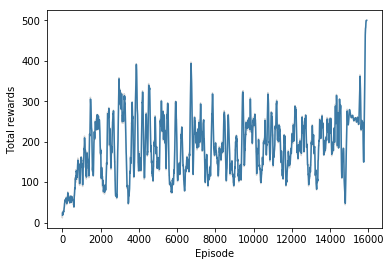

In [30]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

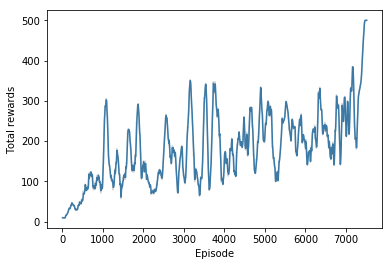

In [29]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

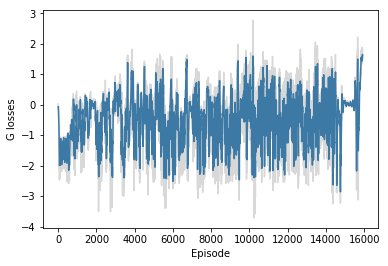

In [31]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

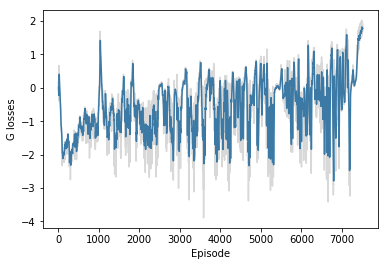

In [30]:
# eps, arr = np.array(g_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('G losses')

Text(0,0.5,'D losses')

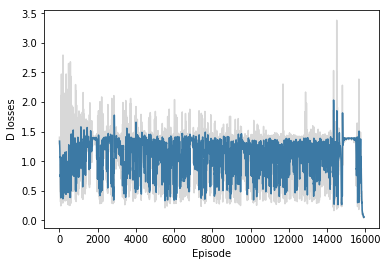

In [32]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

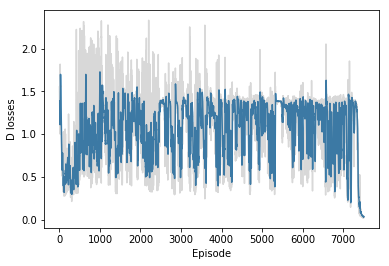

In [31]:
# eps, arr = np.array(d_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses')

Text(0,0.5,'D losses R')

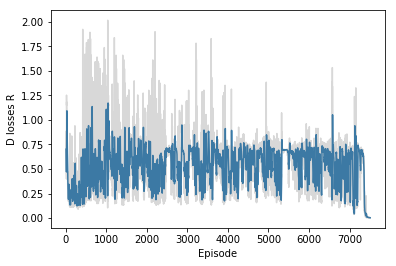

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

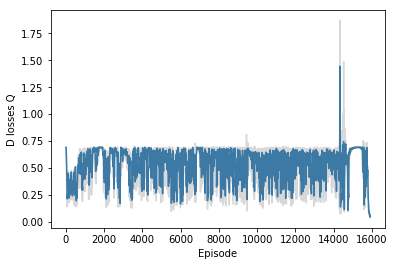

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

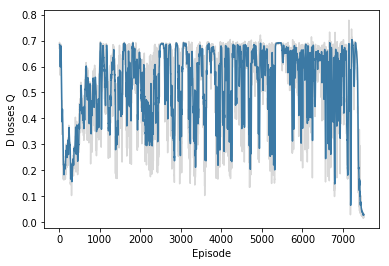

In [33]:
# eps, arr = np.array(d_lossQ_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [ ]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.